In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pickle
import pandas as pd
from glob import glob
from tqdm import tqdm

In [14]:
sys.path.append('/home/akumar/nse/neural_control')

In [15]:
from utils import apply_df_filters

In [5]:
fls = glob('/mnt/Secondary/data/rot/*.pkl')

In [7]:
# Load in the data files
dist_U = []
scores = []
for fl in fls:
    with open(fl, 'rb') as f:
        dist_U.append(pickle.load(f))
        scores.append(pickle.load(f))

In [17]:
# Load the optimized subspaces for comparison
with open('/home/akumar/nse/neural_control/analysis_scripts/jpcaAtmp.dat', 'rb') as f:
    resultsd3 = pickle.load(f)

A_df = pd.DataFrame(resultsd3)
data_files = np.unique(A_df['data_file'].values)
# Measure (1) largest amplification, (2) Angle between largest amplification vector and largest rotation vector, (3) 
d_U = np.zeros((28, 4, 3))
for i in range(28):
    for j, dimreduc_method in enumerate(['DCA', 'KCA', 'LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        # A = df_.iloc[0]['ssid_A']
        # U, P = scipy.linalg.polar(A)
        # d_U[i, j, 0] = np.linalg.norm(A - U)/np.linalg.norm(A)
        A = df_.iloc[0]['var1_A']
        U, P = scipy.linalg.polar(A)
        d_U[i, j, 1] = np.linalg.norm(A - U)/np.linalg.norm(A)
        #d_U[i, j, 1] = 1 - np.linalg.norm(U)/np.linalg.norm(A)
        A = df_.iloc[0]['var2_A']
        U, P = scipy.linalg.polar(A)
        d_U[i, j, 2] = np.linalg.norm(A - U)/np.linalg.norm(A)

In [19]:
np.concatenate(dist_U).ravel().shape

(280100,)

Text(0.5, 0, 'Normalized Distance to Rotational Dynamics')

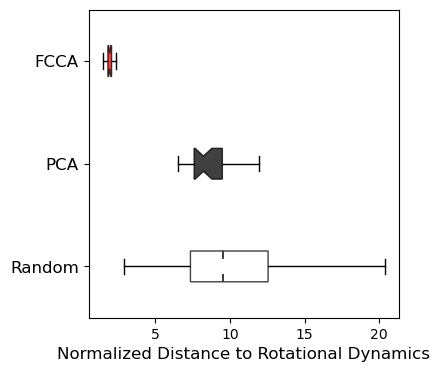

In [33]:
# Plot histograms of the relevant distributions
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
medianprops = dict(linewidth=0)
bplot = ax.boxplot([np.concatenate(dist_U).ravel(), d_U[:, 3, 1].ravel(), d_U[:, 2, 1].ravel()], 
                    patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)
colors = ['white', 'black', 'red']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)

ax.set_yticklabels(['Random', 'PCA', 'FCCA'], fontsize=12)
ax.set_xlabel('Normalized Distance to Rotational Dynamics', fontsize=12)

In [36]:
# Significance testing
_, p1 = scipy.stats.mannwhitneyu(d_U[:, 2, 1].ravel(), np.concatenate(dist_U).ravel(), alternative='less')
# Significance testing
_, p2 = scipy.stats.mannwhitneyu(d_U[:, 3, 1].ravel(), np.concatenate(dist_U).ravel(), alternative='less')

In [35]:
p1

2.4848062670484154e-20

In [37]:
p2

0.03442645129809742

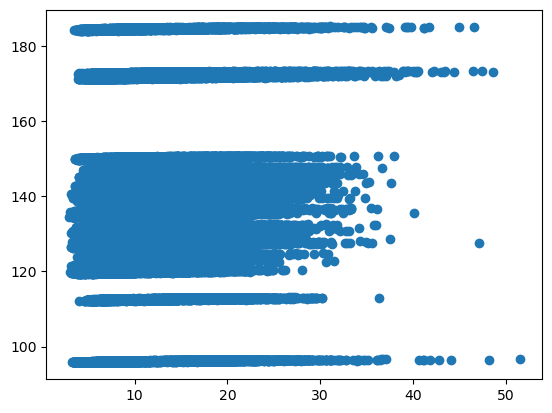

In [39]:
# Scatter scores for dist_U
plt.scatter(np.concatenate(dist_U).ravel(), np.concatenate(scores).ravel())